In [333]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import urllib
import urllib.parse as urlp
import io
import warnings
warnings.filterwarnings("ignore")

from geopy.geocoders import Nominatim

from datetime import datetime, timedelta

%matplotlib inline

import kagglehub
from itertools import cycle

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, auc, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


startDate = "2024-08-01T00"
endDate = "2024-08-01T23"
address = "CN Tower"

splitStartDate = startDate.split('-')
startYear = int(splitStartDate[0])
startMonth = int(splitStartDate[1])
startDaySplit = splitStartDate[2]

day_hour = splitStartDate[2].split('T')
startDay = int(day_hour[0])
startHour = int(day_hour[1])

splitEndDate = endDate.split('-')
endYear = int(splitEndDate[0])
endMonth = int(splitEndDate[1])
endDaySplit = splitEndDate[2]

day_hour_end = splitEndDate[2].split('T')
endDay = int(day_hour[0])
endHour = int(day_hour_end[1])


In [334]:
# Data is sourced from the 'GES DISC Hydrology Time Series Tool'
# https://disc.gsfc.nasa.gov/information/tools?title=Hydrology%20Time%20Series

def get_time_series(start_date,end_date,latitude,longitude,variable):
    """
    Calls the data rods service to get a time series
    """
    base_url = "https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi"
    query_parameters = {
        "variable": variable,
        "type": "asc2",
        "location": f"GEOM:POINT({longitude}, {latitude})",
        "startDate": start_date,
        "endDate": end_date,
    }
    full_url = base_url+"?"+ \
         "&".join(["{}={}".format(key,urlp.quote(query_parameters[key])) for key in query_parameters])
    print(full_url)
    iteration = 0
    done = False
    while not done and iteration < 5:
        r=requests.get(full_url)
        if r.status_code == 200:
            done = True
        else:
            iteration +=1
    
    if not done:
        raise Exception(f"Error code {r.status_code} from url {full_url} : {r.text}")
    
    return r.text

def parse_time_series(ts_str):
    """
    Parses the response from data rods.
    """
    lines = ts_str.split("\n")
    parameters = {}
    for line in lines[2:11]:
        key,value = line.split("=")
        parameters[key] = value
    
    
    df = pd.read_table(io.StringIO(ts_str),sep="\t",
                       names=["time","data"],
                       header=10,parse_dates=["time"])
    return parameters, df

In [335]:
#function for dataframe
def parse_get_time (start_date, end_date, address, variable = "NLDAS2:NLDAS_FORA0125_H_v2.0:Rainf"):


    splitStartDate = startDate.split('-')
    startYear = int(splitStartDate[0])
    startMonth = splitStartDate[1]
    startDay = splitStartDate[2]

    splitEndDate = endDate.split('-')
    endYear = int(splitEndDate[0])
    endMonth = splitEndDate[1]
    endDay = splitEndDate[2]

    prevYear1Start = str(startYear - 1)+"-"+startMonth+"-"+startDay
    prevYear2Start = str(startYear - 2)+"-"+startMonth+"-"+startDay
    prevYear3Start = str(startYear - 3)+"-"+startMonth+"-"+startDay
    prevYear4Start = str(startYear - 4)+"-"+startMonth+"-"+startDay
    prevYear5Start = str(startYear - 5)+"-"+startMonth+"-"+startDay
    prevYear6Start = str(startYear - 6)+"-"+startMonth+"-"+startDay
    prevYear7Start = str(startYear - 7)+"-"+startMonth+"-"+startDay
    prevYear8Start = str(startYear - 8)+"-"+startMonth+"-"+startDay
    prevYear9Start = str(startYear - 9)+"-"+startMonth+"-"+startDay
    prevYear10Start = str(startYear - 10)+"-"+startMonth+"-"+startDay

    prevYear1End = str(endYear - 1)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear2End = str(endYear - 2)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear3End = str(endYear - 3)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear4End = str(endYear - 4)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear5End = str(endYear - 5)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear6End = str(endYear - 6)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear7End = str(endYear - 7)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear8End = str(endYear - 8)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear9End = str(endYear - 9)+"-"+str(endMonth)+"-"+str(endDay)
    prevYear10End = str(endYear - 10)+"-"+str(endMonth)+"-"+str(endDay)

    # Initialize the geolocator with a user agent (required by Nominatim)
    # Replace "your_app_name" with a descriptive name for your application
    geolocator = Nominatim(user_agent="geo_app_hackathon_UML_BUILDERS")

    # Define the address or place name you want to geocode

    # Geocode the address
    location = geolocator.geocode(address)

    # Check if a location was found
    if location:
        #print(f"Address: {location.address}")
        latitude = location.latitude
        #print(f"Latitude: {latitude}")
        longitude = location.longitude
        #print(f"Longitude: {longitude}")
    else:
        print(f"Location not found for: {address}")
        return

    df_precip1 = parse_time_series(get_time_series(prevYear1Start, prevYear1End, latitude, longitude, variable))
    df_precip2 = parse_time_series(get_time_series(prevYear2Start, prevYear2End, latitude, longitude, variable))
    df_precip3 = parse_time_series(get_time_series(prevYear3Start, prevYear3End, latitude, longitude, variable))
    df_precip4 = parse_time_series(get_time_series(prevYear4Start, prevYear4End, latitude, longitude, variable))
    df_precip5 = parse_time_series(get_time_series(prevYear5Start, prevYear5End, latitude, longitude, variable))
    df_precip6 = parse_time_series(get_time_series(prevYear6Start, prevYear6End, latitude, longitude, variable))
    df_precip7 = parse_time_series(get_time_series(prevYear7Start, prevYear7End, latitude, longitude, variable))
    df_precip8 = parse_time_series(get_time_series(prevYear8Start, prevYear8End, latitude, longitude, variable))
    df_precip9 = parse_time_series(get_time_series(prevYear9Start, prevYear9End, latitude, longitude, variable))
    df_precip10 = parse_time_series(get_time_series(prevYear10Start, prevYear10End, latitude, longitude, variable))

    df_humid1 =parse_time_series(get_time_series(prevYear1Start, prevYear1End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid2 =parse_time_series(get_time_series(prevYear2Start, prevYear2End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid3 =parse_time_series(get_time_series(prevYear3Start, prevYear3End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid4 =parse_time_series(get_time_series(prevYear4Start, prevYear4End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid5 =parse_time_series(get_time_series(prevYear5Start, prevYear5End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid6 =parse_time_series(get_time_series(prevYear6Start, prevYear6End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid7 =parse_time_series(get_time_series(prevYear7Start, prevYear7End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid8 =parse_time_series(get_time_series(prevYear8Start, prevYear8End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid9 =parse_time_series(get_time_series(prevYear9Start, prevYear9End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))
    df_humid10 =parse_time_series(get_time_series(prevYear10Start, prevYear10End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Qair"))

    df_airtemp1 =parse_time_series(get_time_series(prevYear1Start, prevYear1End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp2 =parse_time_series(get_time_series(prevYear2Start, prevYear2End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp3 =parse_time_series(get_time_series(prevYear3Start, prevYear3End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp4 =parse_time_series(get_time_series(prevYear4Start, prevYear4End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp5 =parse_time_series(get_time_series(prevYear5Start, prevYear5End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp6 =parse_time_series(get_time_series(prevYear6Start, prevYear6End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp7 =parse_time_series(get_time_series(prevYear7Start, prevYear7End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp8 =parse_time_series(get_time_series(prevYear8Start, prevYear8End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp9 =parse_time_series(get_time_series(prevYear9Start, prevYear9End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))
    df_airtemp10 =parse_time_series(get_time_series(prevYear10Start, prevYear10End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Tair"))

    df_wSpeedN1 =parse_time_series(get_time_series(prevYear1Start, prevYear1End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN2 =parse_time_series(get_time_series(prevYear2Start, prevYear2End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN3 =parse_time_series(get_time_series(prevYear3Start, prevYear3End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN4 =parse_time_series(get_time_series(prevYear4Start, prevYear4End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN5 =parse_time_series(get_time_series(prevYear5Start, prevYear5End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN6 =parse_time_series(get_time_series(prevYear6Start, prevYear6End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN7 =parse_time_series(get_time_series(prevYear7Start, prevYear7End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN8 =parse_time_series(get_time_series(prevYear8Start, prevYear8End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN9 =parse_time_series(get_time_series(prevYear9Start, prevYear9End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))
    df_wSpeedN10 =parse_time_series(get_time_series(prevYear10Start, prevYear10End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_N"))

    df_wSpeedE1 =parse_time_series(get_time_series(prevYear1Start, prevYear1End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE2 =parse_time_series(get_time_series(prevYear2Start, prevYear2End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE3 =parse_time_series(get_time_series(prevYear3Start, prevYear3End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE4 =parse_time_series(get_time_series(prevYear4Start, prevYear4End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE5 =parse_time_series(get_time_series(prevYear5Start, prevYear5End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE6 =parse_time_series(get_time_series(prevYear6Start, prevYear6End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE7 =parse_time_series(get_time_series(prevYear7Start, prevYear7End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE8 =parse_time_series(get_time_series(prevYear8Start, prevYear8End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE9 =parse_time_series(get_time_series(prevYear9Start, prevYear9End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))
    df_wSpeedE10 =parse_time_series(get_time_series(prevYear10Start, prevYear10End, latitude, longitude, "NLDAS2:NLDAS_FORA0125_H_v2.0:Wind_E"))

    dp1 = {'time': pd.to_datetime(df_precip1[1]['time'], unit='s'), 'Rainf': df_precip1[1]['data']}
    dp2 = {'time': pd.to_datetime(df_precip2[1]['time'], unit='s'), 'Rainf': df_precip2[1]['data']}
    dp3 = {'time': pd.to_datetime(df_precip3[1]['time'], unit='s'), 'Rainf': df_precip3[1]['data']}
    dp4 = {'time': pd.to_datetime(df_precip4[1]['time'], unit='s'), 'Rainf': df_precip4[1]['data']}
    dp5 = {'time': pd.to_datetime(df_precip5[1]['time'], unit='s'), 'Rainf': df_precip5[1]['data']}
    dp6 = {'time': pd.to_datetime(df_precip6[1]['time'], unit='s'), 'Rainf': df_precip6[1]['data']}
    dp7 = {'time': pd.to_datetime(df_precip7[1]['time'], unit='s'), 'Rainf': df_precip7[1]['data']}
    dp8 = {'time': pd.to_datetime(df_precip8[1]['time'], unit='s'), 'Rainf': df_precip8[1]['data']}
    dp9 = {'time': pd.to_datetime(df_precip9[1]['time'], unit='s'), 'Rainf': df_precip9[1]['data']}
    dp10 = {'time': pd.to_datetime(df_precip10[1]['time'], unit='s'), 'Rainf': df_precip10[1]['data']}

    dh1 = {'time': pd.to_datetime(df_humid1[1]['time'], unit='s'), 'Qair': df_humid1[1]['data']}
    dh2 = {'time': pd.to_datetime(df_humid2[1]['time'], unit='s'), 'Qair': df_humid2[1]['data']}
    dh3 = {'time': pd.to_datetime(df_humid3[1]['time'], unit='s'), 'Qair': df_humid3[1]['data']}
    dh4 = {'time': pd.to_datetime(df_humid4[1]['time'], unit='s'), 'Qair': df_humid4[1]['data']}
    dh5 = {'time': pd.to_datetime(df_humid5[1]['time'], unit='s'), 'Qair': df_humid5[1]['data']}
    dh6 = {'time': pd.to_datetime(df_humid6[1]['time'], unit='s'), 'Qair': df_humid6[1]['data']}
    dh7 = {'time': pd.to_datetime(df_humid7[1]['time'], unit='s'), 'Qair': df_humid7[1]['data']}
    dh8 = {'time': pd.to_datetime(df_humid8[1]['time'], unit='s'), 'Qair': df_humid8[1]['data']}
    dh9 = {'time': pd.to_datetime(df_humid9[1]['time'], unit='s'), 'Qair': df_humid9[1]['data']}
    dh10 = {'time': pd.to_datetime(df_humid10[1]['time'], unit='s'), 'Qair': df_humid10[1]['data']}

    da1 = {'time': pd.to_datetime(df_airtemp1[1]['time'], unit='s'), 'Tair': df_airtemp1[1]['data']}
    da2 = {'time': pd.to_datetime(df_airtemp2[1]['time'], unit='s'), 'Tair': df_airtemp2[1]['data']}
    da3 = {'time': pd.to_datetime(df_airtemp3[1]['time'], unit='s'), 'Tair': df_airtemp3[1]['data']}
    da4 = {'time': pd.to_datetime(df_airtemp4[1]['time'], unit='s'), 'Tair': df_airtemp4[1]['data']}
    da5 = {'time': pd.to_datetime(df_airtemp5[1]['time'], unit='s'), 'Tair': df_airtemp5[1]['data']}
    da6 = {'time': pd.to_datetime(df_airtemp6[1]['time'], unit='s'), 'Tair': df_airtemp6[1]['data']}
    da7 = {'time': pd.to_datetime(df_airtemp7[1]['time'], unit='s'), 'Tair': df_airtemp7[1]['data']}
    da8 = {'time': pd.to_datetime(df_airtemp8[1]['time'], unit='s'), 'Tair': df_airtemp8[1]['data']}
    da9 = {'time': pd.to_datetime(df_airtemp9[1]['time'], unit='s'), 'Tair': df_airtemp9[1]['data']}
    da10 = {'time': pd.to_datetime(df_airtemp10[1]['time'], unit='s'), 'Tair': df_airtemp10[1]['data']}

    dwn1 = {'time': pd.to_datetime(df_wSpeedN1[1]['time'], unit='s'), 'Wind_N': df_wSpeedN1[1]['data']}
    dwn2 = {'time': pd.to_datetime(df_wSpeedN2[1]['time'], unit='s'), 'Wind_N': df_wSpeedN2[1]['data']}
    dwn3 = {'time': pd.to_datetime(df_wSpeedN3[1]['time'], unit='s'), 'Wind_N': df_wSpeedN3[1]['data']}
    dwn4 = {'time': pd.to_datetime(df_wSpeedN4[1]['time'], unit='s'), 'Wind_N': df_wSpeedN4[1]['data']}
    dwn5 = {'time': pd.to_datetime(df_wSpeedN5[1]['time'], unit='s'), 'Wind_N': df_wSpeedN5[1]['data']}
    dwn6 = {'time': pd.to_datetime(df_wSpeedN6[1]['time'], unit='s'), 'Wind_N': df_wSpeedN6[1]['data']}
    dwn7 = {'time': pd.to_datetime(df_wSpeedN7[1]['time'], unit='s'), 'Wind_N': df_wSpeedN7[1]['data']}
    dwn8 = {'time': pd.to_datetime(df_wSpeedN8[1]['time'], unit='s'), 'Wind_N': df_wSpeedN8[1]['data']}
    dwn9 = {'time': pd.to_datetime(df_wSpeedN9[1]['time'], unit='s'), 'Wind_N': df_wSpeedN9[1]['data']}
    dwn10 = {'time': pd.to_datetime(df_wSpeedN10[1]['time'], unit='s'), 'Wind_N': df_wSpeedN10[1]['data']}

    dwe1 = {'time': pd.to_datetime(df_wSpeedE1[1]['time'], unit='s'), 'Wind_E': df_wSpeedE1[1]['data']}
    dwe2 = {'time': pd.to_datetime(df_wSpeedE2[1]['time'], unit='s'), 'Wind_E': df_wSpeedE2[1]['data']}
    dwe3 = {'time': pd.to_datetime(df_wSpeedE3[1]['time'], unit='s'), 'Wind_E': df_wSpeedE3[1]['data']}
    dwe4 = {'time': pd.to_datetime(df_wSpeedE4[1]['time'], unit='s'), 'Wind_E': df_wSpeedE4[1]['data']}
    dwe5 = {'time': pd.to_datetime(df_wSpeedE5[1]['time'], unit='s'), 'Wind_E': df_wSpeedE5[1]['data']}
    dwe6 = {'time': pd.to_datetime(df_wSpeedE6[1]['time'], unit='s'), 'Wind_E': df_wSpeedE6[1]['data']}
    dwe7 = {'time': pd.to_datetime(df_wSpeedE7[1]['time'], unit='s'), 'Wind_E': df_wSpeedE7[1]['data']}
    dwe8 = {'time': pd.to_datetime(df_wSpeedE8[1]['time'], unit='s'), 'Wind_E': df_wSpeedE8[1]['data']}
    dwe9 = {'time': pd.to_datetime(df_wSpeedE9[1]['time'], unit='s'), 'Wind_E': df_wSpeedE9[1]['data']}
    dwe10 = {'time': pd.to_datetime(df_wSpeedE10[1]['time'], unit='s'), 'Wind_E': df_wSpeedE10[1]['data']}

    dfp1 =  pd.DataFrame(data=dp1)
    dfp2 =  pd.DataFrame(data=dp2)
    dfp3 =  pd.DataFrame(data=dp3)
    dfp4 =  pd.DataFrame(data=dp4)
    dfp5 =  pd.DataFrame(data=dp5)
    dfp6 =  pd.DataFrame(data=dp6)
    dfp7 =  pd.DataFrame(data=dp7)
    dfp8 =  pd.DataFrame(data=dp8)
    dfp9 =  pd.DataFrame(data=dp9)
    dfp10 = pd.DataFrame(data=dp10)

    dfh1 = pd.DataFrame(data=dh1)
    dfh2 = pd.DataFrame(data=dh2)
    dfh3 = pd.DataFrame(data=dh3)
    dfh4 = pd.DataFrame(data=dh4)
    dfh5 = pd.DataFrame(data=dh5)
    dfh6 = pd.DataFrame(data=dh6)
    dfh7 = pd.DataFrame(data=dh7)
    dfh8 = pd.DataFrame(data=dh8)
    dfh9 = pd.DataFrame(data=dh9)
    dfh10 = pd.DataFrame(data=dh10)

    dfa1 = pd.DataFrame(data=da1)
    dfa2 = pd.DataFrame(data=da2)
    dfa3 = pd.DataFrame(data=da3)
    dfa4 = pd.DataFrame(data=da4)
    dfa5 = pd.DataFrame(data=da5)
    dfa6 = pd.DataFrame(data=da6)
    dfa7 = pd.DataFrame(data=da7)
    dfa8 = pd.DataFrame(data=da8)
    dfa9 = pd.DataFrame(data=da9)
    dfa10 = pd.DataFrame(data=da10)

    dfwn1 = pd.DataFrame(data=dwn1)
    dfwn2 = pd.DataFrame(data=dwn2)
    dfwn3 = pd.DataFrame(data=dwn3)
    dfwn4 = pd.DataFrame(data=dwn4)
    dfwn5 = pd.DataFrame(data=dwn5)
    dfwn6 = pd.DataFrame(data=dwn6)
    dfwn7 = pd.DataFrame(data=dwn7)
    dfwn8 = pd.DataFrame(data=dwn8)
    dfwn9 = pd.DataFrame(data=dwn9)
    dfwn10 = pd.DataFrame(data=dwn10)

    dfwe1 = pd.DataFrame(data=dwe1)
    dfwe2 = pd.DataFrame(data=dwe2)
    dfwe3 = pd.DataFrame(data=dwe3)
    dfwe4 = pd.DataFrame(data=dwe4)
    dfwe5 = pd.DataFrame(data=dwe5)
    dfwe6 = pd.DataFrame(data=dwe6)
    dfwe7 = pd.DataFrame(data=dwe7)
    dfwe8 = pd.DataFrame(data=dwe8)
    dfwe9 = pd.DataFrame(data=dwe9)
    dfwe10 = pd.DataFrame(data=dwe10)

    frames1 = [dfp1,dfp2,dfp3,dfp4,dfp5,dfp6,dfp7,dfp8,dfp9,dfp10]
    frames2 = [dfh1,dfh2,dfh3,dfh4,dfh5,dfh6,dfh7,dfh8,dfh9,dfh10]
    frames3 = [dfa1,dfa2,dfa3,dfa4,dfa5,dfa6,dfa7,dfa8,dfa9,dfa10]
    frames4 = [dfwn1,dfwn2,dfwn3,dfwn4,dfwn5,dfwn6,dfwn7,dfwn8,dfwn9,dfwn10]
    frames5 = [dfwe1,dfwe2,dfwe3,dfwe4,dfwe5,dfwe6,dfwe7,dfwe8,dfwe9,dfwe10]


    for x in frames1:
        x["Humidity"] = ""
        x["Air Temperature"] = ""
        x["Wind_N"] =""
        x["Wind_E"] = ""
        # x["TimeOfDay"] = ""
        # x["Year"] = ""
        # x["Month"] = ""
        # x["Day"] = ""
        # x["Hour"] = ""
        x["Weather"] = ""

        # time_of_day = (
        #     [0] * 3 +       # Night,     0,1,2
        #     [1] * 6 +       # Morning,   3,4,5,6,7,8
        #     [2] * 6 +       # Afternoon, 9,10,11,12,13,14
        #     [3] * 6 +       # Evening,   15,16,17,18,19,20
        #     [0] * 3         # Night,     21,22,23 
        # )

        # x['TimeOfDay'] = time_of_day

    for i in range(len(frames1)):
        frames1[i]['Humidity']= frames2[i]['Qair']
        frames1[i]['Air Temperature']= frames3[i]['Tair']
        frames1[i]['Wind_N']= frames4[i]['Wind_N']
        frames1[i]['Wind_E']= frames5[i]['Wind_E']

    for x in frames1:
        x['time'] = x['time'].astype(str)

        # datetime_col = pd.to_datetime(x['time'].str.split(',').str[0], errors='coerce')
        # x['Year'] = datetime_col.dt.year
        # x['Month'] = datetime_col.dt.month
        # x['Day'] = datetime_col.dt.day
        # x['Hour'] = datetime_col.dt.hour 

    for x in frames1:
        for i in range(len(x)):
            if x.loc[i, 'Rainf'] == 0.0:
                x.loc[i, 'Weather'] = "No Rain"         # 0 # No Rain
            elif x.loc[i, 'Rainf'] > 0.0 and x.loc[i, 'Rainf'] <= 0.25 :
                x.loc[i, 'Weather'] = "Very Light Rain" # 1 # Very Light
            elif x.loc[i, 'Rainf'] > 0.25 and x.loc[i, 'Rainf'] <= 1.0 :
                x.loc[i, 'Weather'] = "Light Rain"      # 2 # Light
            elif x.loc[i, 'Rainf'] > 1.0 and x.loc[i, 'Rainf'] <= 4.0 :
                x.loc[i, 'Weather'] = "Moderate Rain"   # 3 # Moderate
            elif x.loc[i, 'Rainf'] > 4.0 and x.loc[i, 'Rainf'] <= 16 :
                x.loc[i, 'Weather'] = "Heavy Rain"      # 4 # Heavy
            elif x.loc[i, 'Rainf'] > 16 and x.loc[i, 'Rainf'] <= 50 :
                x.loc[i, 'Weather'] = "Very Heavy Rain" # 5 # Very Heavy
            elif x.loc[i, 'Rainf'] > 50 :
                x.loc[i, 'Weather'] = "Extreme Rain"    # 6 # Extreme   

    # for x in frames1:
    #     x.drop(columns=['time'], inplace = True)

    df = pd.concat(frames1)

    df.to_csv('tenYears.csv', index = False)


#parse_get_time("2024-08-01T00", "2024-08-01T23", "CN Tower")

In [336]:
# parse_get_time("2024-08-01T00", "2024-08-01T23", "CN Tower")

parse_get_time("2024-08-01T00", "2024-08-01T23", "CN Tower")

https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ARainf&type=asc2&location=GEOM%3APOINT%28-79.3870872%2C%2043.6425637%29&startDate=2023-08-01T00&endDate=2023-08-01T23
https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ARainf&type=asc2&location=GEOM%3APOINT%28-79.3870872%2C%2043.6425637%29&startDate=2022-08-01T00&endDate=2022-08-01T23
https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ARainf&type=asc2&location=GEOM%3APOINT%28-79.3870872%2C%2043.6425637%29&startDate=2021-08-01T00&endDate=2021-08-01T23
https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS2%3ANLDAS_FORA0125_H_v2.0%3ARainf&type=asc2&location=GEOM%3APOINT%28-79.3870872%2C%2043.6425637%29&startDate=2020-08-01T00&endDate=2020-08-01T23
https://hydro1.gesdisc.eosdis.nasa.gov/daac-bin/access/timeseries.cgi?variable=NLDAS

In [337]:
data = pd.read_csv('tenYears.csv')

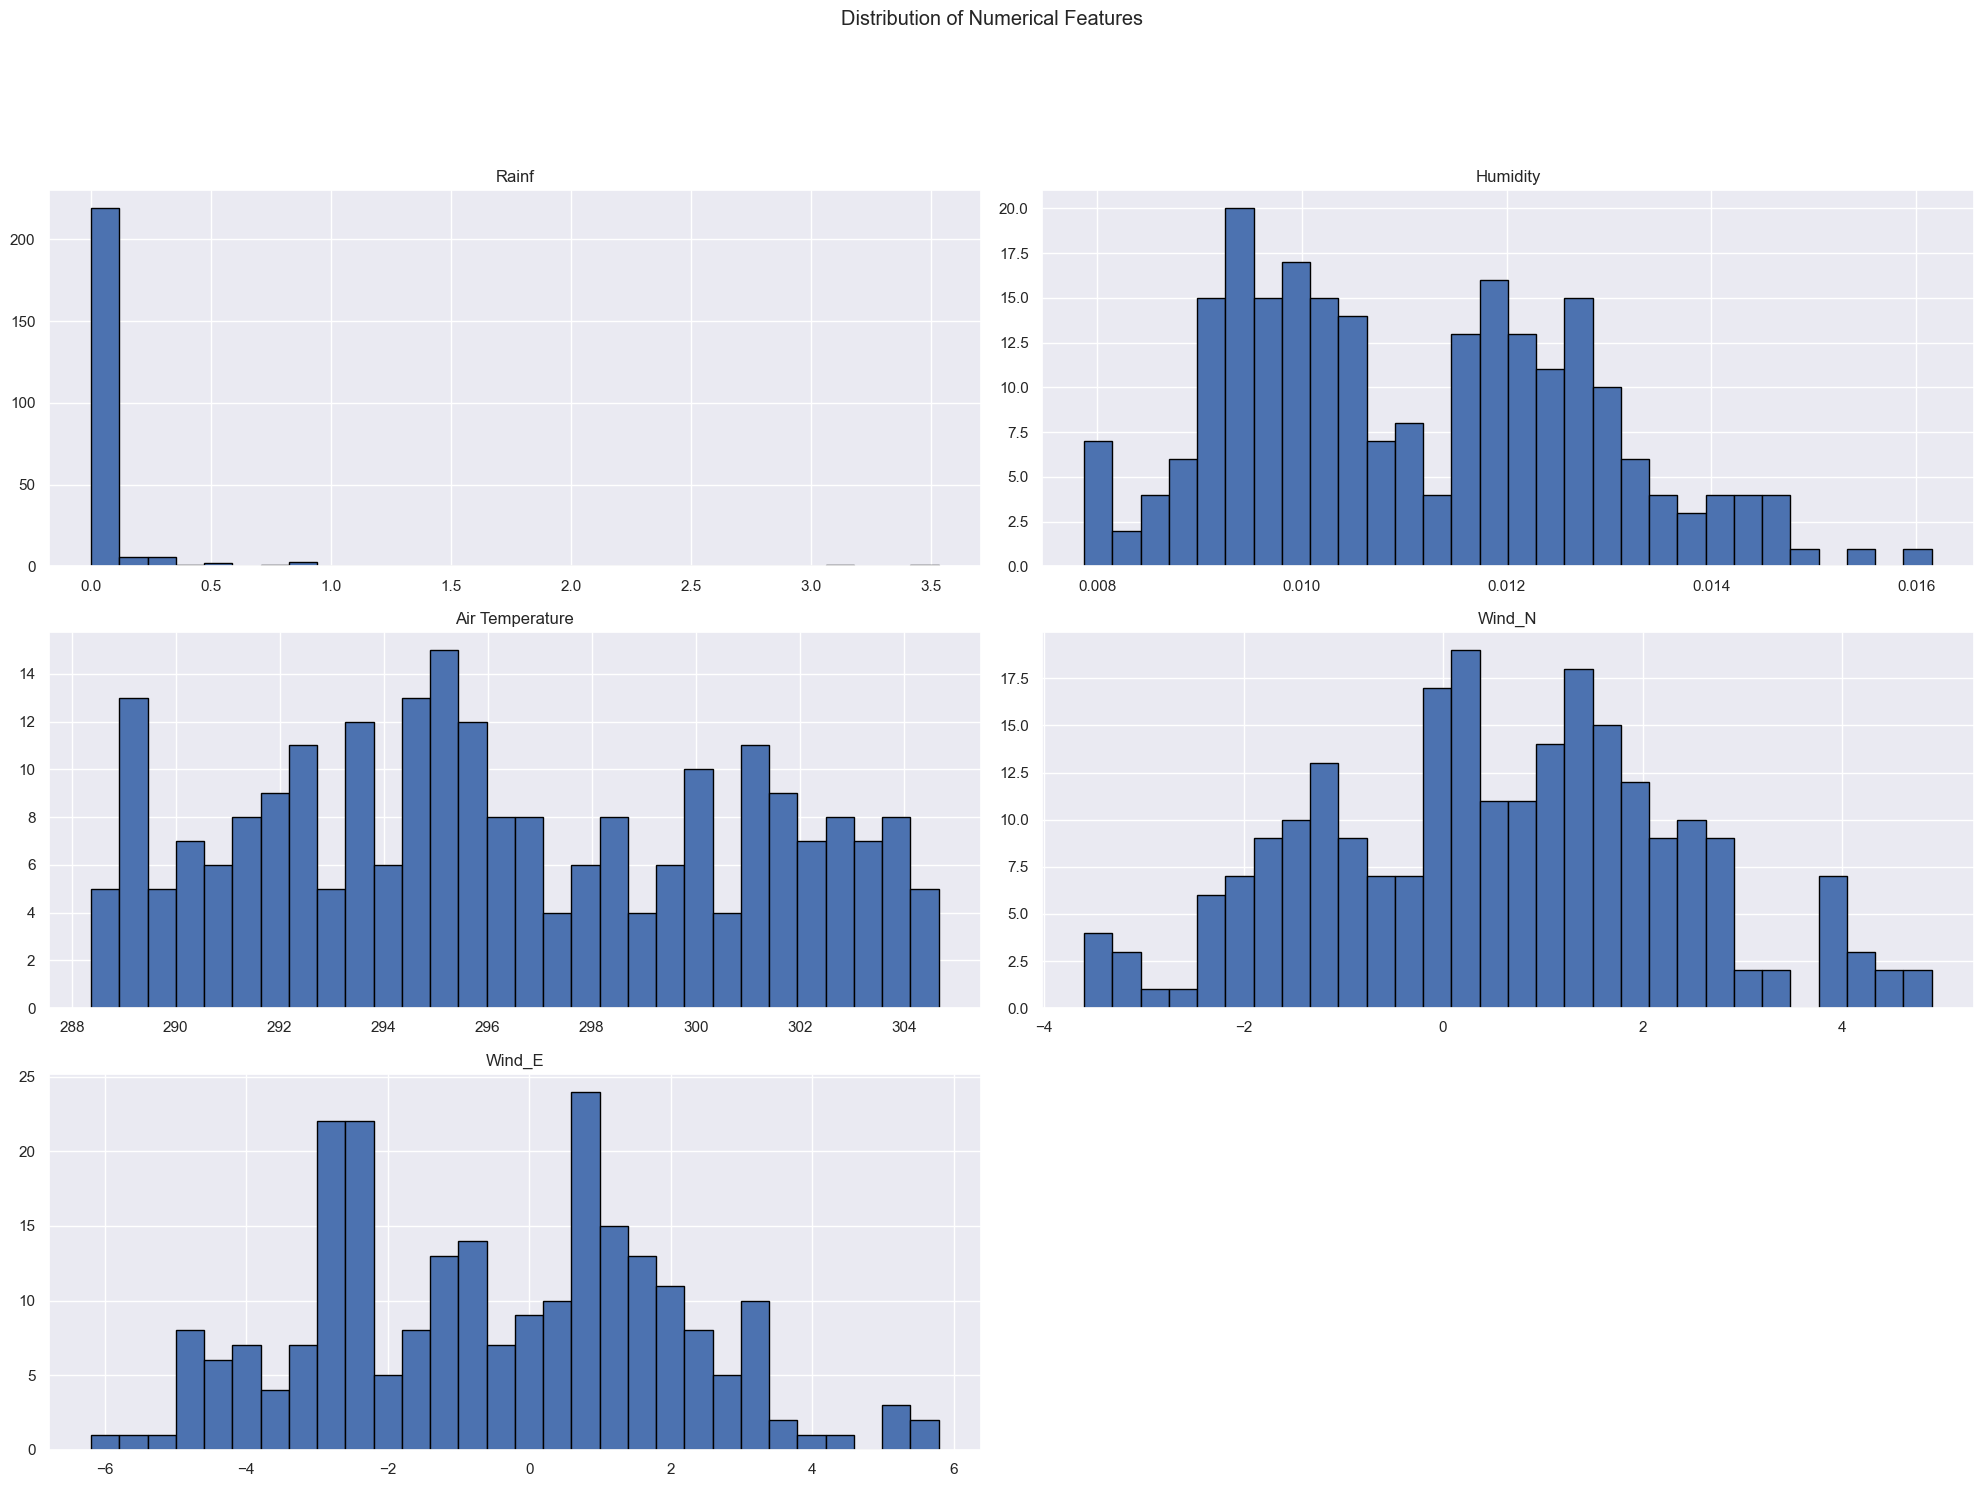

In [338]:
numerical_cols = data.select_dtypes(include=np.number).columns

data[numerical_cols].hist(figsize=(20, 15), bins=30, edgecolor='black')
plt.suptitle('Distribution of Numerical Features', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

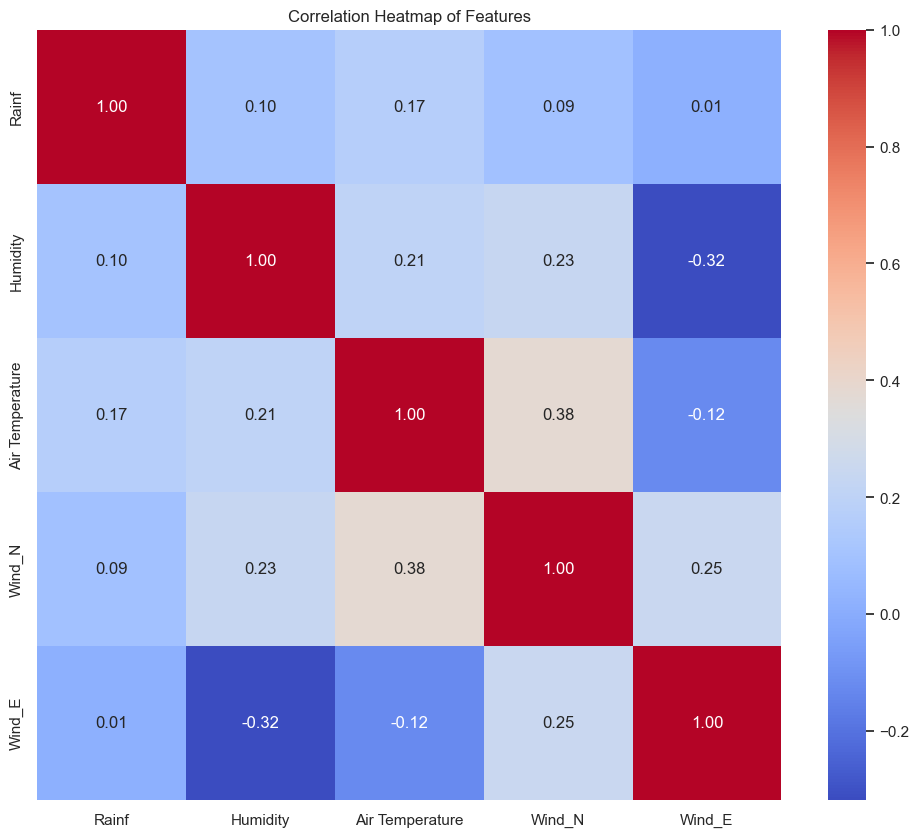

In [339]:
# Calculate the correlation matrix
corr_matrix = data.drop(['Weather', 'time'], axis=1).corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Features')
plt.show()

In [340]:
# Separate features (X) and target (y)
X = data.drop(['Weather', 'time'], axis=1) # Drop both 'weather' and 'date' from features
y = data['Weather']

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [342]:
feature_scaler = RobustScaler()

# Select all columns in X_train for scaling
numerical_cols_features = X_train.select_dtypes(include=np.number).columns

X_train[numerical_cols_features] = feature_scaler.fit_transform(X_train[numerical_cols_features])
X_test[numerical_cols_features] = feature_scaler.transform(X_test[numerical_cols_features])


# Combine train and test labels temporarily to get consistent dummy columns
all_classes = pd.Series(list(y_train) + list(y_test))

# Use get_dummies on both with the same columns
y_train_encoded = pd.get_dummies(y_train).reindex(columns=all_classes.unique(), fill_value=0)
y_test_encoded  = pd.get_dummies(y_test).reindex(columns=all_classes.unique(), fill_value=0)

y_train_encoded = y_train_encoded.astype(np.float32)
y_test_encoded  = y_test_encoded.astype(np.float32)

# One-hot encode the target variable
# y_train_encoded = pd.get_dummies(y_train)
# y_test_encoded = pd.get_dummies(y_test)

print(y_test_encoded)

# Check data types of X_train before training
print("Data types of X_train after scaling:")
print(X_train.dtypes)

     No Rain  Very Light Rain  Moderate Rain  Light Rain
24       1.0              0.0            0.0         0.0
6        1.0              0.0            0.0         0.0
93       0.0              1.0            0.0         0.0
109      1.0              0.0            0.0         0.0
104      1.0              0.0            0.0         0.0
172      1.0              0.0            0.0         0.0
233      1.0              0.0            0.0         0.0
86       1.0              0.0            0.0         0.0
9        1.0              0.0            0.0         0.0
143      0.0              0.0            0.0         1.0
45       1.0              0.0            0.0         0.0
206      1.0              0.0            0.0         0.0
114      1.0              0.0            0.0         0.0
168      1.0              0.0            0.0         0.0
113      1.0              0.0            0.0         0.0
230      1.0              0.0            0.0         0.0
185      0.0              1.0  

In [343]:
# # Assume input is shaped as (timesteps, features)
# timesteps = X_train.shape[1]       # number of time steps
# features = X_train.shape[2] if len(X_train.shape) == 3 else 1

# num_classes = 4  # since you want 4 classes

# print("y_train unique values:", np.unique(y_train))
# print("y_test unique values:", np.unique(y_test))

# y_train_zero_based = y_train - 1
# y_test_zero_based  = y_test - 1

# y_train_encoded = to_categorical(y_train_zero_based, num_classes=num_classes)
# y_test_encoded  = to_categorical(y_test_zero_based, num_classes=num_classes)

# print(y_train_encoded.shape)  # should be (num_samples, 4)
# print(y_test_encoded.shape)   # should be (num_samples, 4)

# model = Sequential([
#     # First GRU block
#     GRU(256, return_sequences=True, input_shape=(timesteps, features)),

#     # Second GRU block
#     GRU(128, return_sequences=True),

#     # Third GRU block
#     GRU(64, return_sequences=True),

#     # Fourth GRU block
#     GRU(64),

#     # Fully connected layers
#     Dense(128, activation='relu'),

#     Dense(64, activation='relu'),

#     # Output layer
#     Dense(y_train_encoded.shape[1], activation='softmax')
# ])

# # Compile with lower learning rate
# optimizer = Adam(learning_rate=1e-3)
# model.compile(optimizer=optimizer,
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [344]:
# # Assume your input is shaped as (timesteps, features)
# timesteps = X_train.shape[1]       # number of time steps
# features = X_train.shape[2]

# num_classes = y_train_encoded.shape[1]

# model = Sequential([
#     # First GRU block
#     GRU(256, return_sequences=True, input_shape=(timesteps, features)),

#     # Second GRU block
#     GRU(128, return_sequences=True),

#     # Third GRU block
#     GRU(64, return_sequences=True),

#     # Fourth GRU block
#     GRU(64),

#     # Fully connected layers
#     Dense(128, activation='relu'),

#     Dense(64, activation='relu'),

#     # Output layer
#     Dense(y_train_encoded.shape[1], activation='softmax')
# ])

# # Compile with lower learning rate
# optimizer = Adam(learning_rate=1e-3)
# model.compile(optimizer=optimizer,
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# model.summary()

In [345]:
# Assume your input is shaped as (timesteps, features)
# timesteps = X_train.shape[1]       # number of time steps
# features = X_train.shape[2] if len(X_train.shape) == 3 else 1

X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test  = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

timesteps = 1
features = X_train.shape[2]

model = Sequential([
    # First GRU block
    GRU(256, return_sequences=True, input_shape=(timesteps, features)),

    # Second GRU block
    GRU(128, return_sequences=True),

    # Third GRU block
    GRU(64, return_sequences=True),

    # Fourth GRU block
    GRU(64),

    # Fully connected layers
    Dense(128, activation='relu'),

    Dense(64, activation='relu'),

    # Output layer
    Dense(y_train_encoded.shape[1], activation='softmax')
])

# Compile with lower learning rate
optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_84 (GRU)                    │ (None, 1, 256)         │       201,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_85 (GRU)                    │ (None, 1, 128)         │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_86 (GRU)                    │ (None, 1, 64)          │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_87 (GRU)                    │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,252 (1.64 MB)

 Trainable params: 429,252 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

In [346]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=0)
]

history = model.fit(
    X_train, y_train_encoded,
    validation_data=(X_test, y_test_encoded),
    epochs=100,
    callbacks=callbacks,
)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.7292 - loss: 1.3546 - val_accuracy: 0.9167 - val_loss: 1.2839 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8750 - loss: 1.2165 - val_accuracy: 0.9583 - val_loss: 1.0586 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8906 - loss: 0.9589 - val_accuracy: 0.9583 - val_loss: 0.6699 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8906 - loss: 0.5711 - val_accuracy: 0.9583 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8906 - loss: 0.2892 - val_accuracy: 0.9583 - val_loss: 0.0902 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9115 - loss: 0.1900 - val_accuracy: 0.9792 - val_loss: 0.0535 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9740 - loss: 0.1216 - val_accuracy:

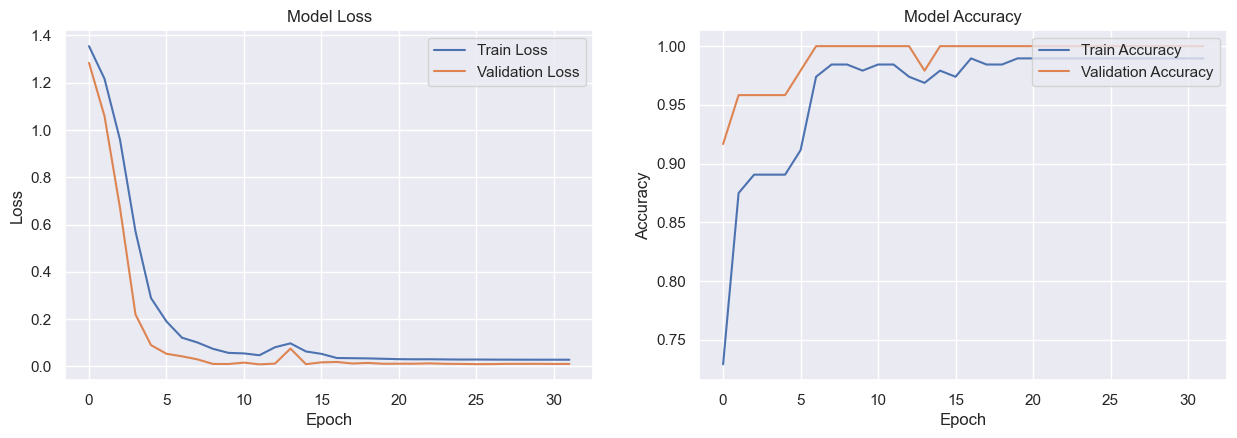

In [347]:
# Plot Model Loss
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot Model Accuracy
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

In [348]:
# Predict probabilities for the test set
y_score = model.predict(X_test)

# Number of classes
n_classes = y_test_encoded.shape[1]

# Get true labels as indices
y_true_labels = np.argmax(y_test_encoded, axis=1)

# Get predicted labels as indices
y_pred_indices = np.argmax(y_score, axis=1)

# Define class labels (adjust if your original labels are strings)
# For integer labels 0,1,2,3:
# class_labels = np.arange(n_classes)
class_labels = ['No Rain', 'Very Light Rain', 'Light Rain', 'Moderate Rain']

# Map indices to class labels (optional if you want string labels)
y_true_labels_str = [class_labels[i] for i in y_true_labels]
y_pred_labels_str = [class_labels[i] for i in y_pred_indices]

# Compute confusion matrix
cm = confusion_matrix(y_true_labels_str, y_pred_labels_str)
print(cm)

# Optional: classification report
report = classification_report(y_true_labels_str, y_pred_labels_str)
print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
[[ 2  0  0]
 [ 0 38  0]
 [ 0  0  8]]
                 precision    recall  f1-score   support

  Moderate Rain       1.00      1.00      1.00         2
        No Rain       1.00      1.00      1.00        38
Very Light Rain       1.00      1.00      1.00         8

       accuracy                           1.00        48
      macro avg       1.00      1.00      1.00        48
   weighted avg       1.00      1.00      1.00        48



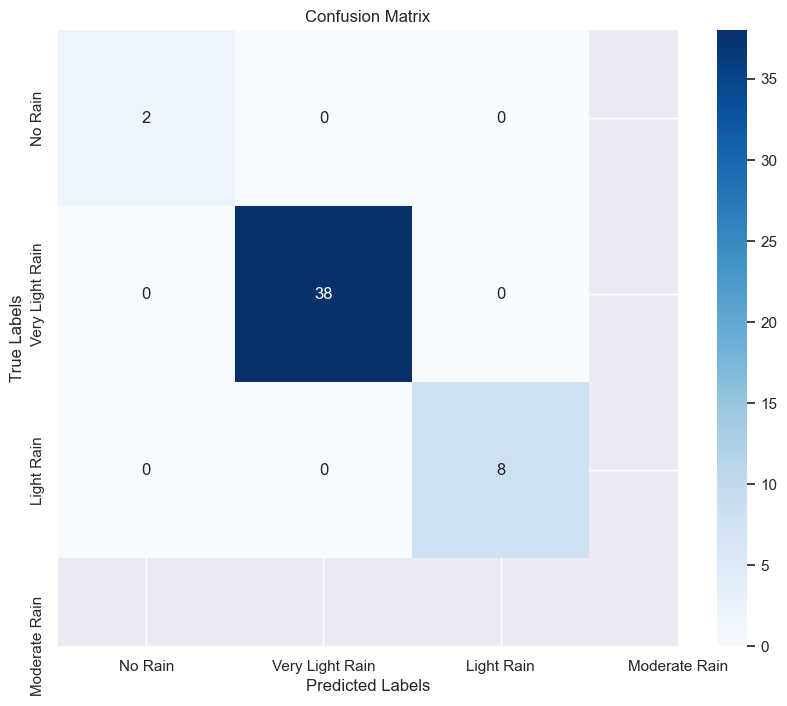

In [349]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')

plt.show()

In [350]:
model.save('Petrichor_Model.keras')

In [351]:
model.summary

<bound method Model.summary of <Sequential name=sequential_21, built=True>>

In [352]:
# myTest = {
#         'Rainf'           : [0],
#         'Humidity'        : [0],
#         'Air Temperature' : [0],
#         'Wind_N'          : [0],
#         'Wind_E'          : [0],
#         'TimeOfDay'       : [0],
#         'Year'            : [startYear],
#         'Month'           : [startMonth],
#         'Day'             : [startDay],
#         'Hour'            : [startHour],
#         'Weather'         : [0],
#     }
# df = pd.DataFrame(myTest)
# print(model.predict(df))

# y_pred_probs = model.predict(X_test)

In [353]:

# def query_gru(model, x_input, label_encoder=None):
#     """
#     Query a trained GRU model and return human-readable predictions.
    
#     Parameters:
#     - model: Trained Keras GRU model
#     - x_input: Input data, shape (timesteps, features) or (samples, timesteps, features)
#     - label_encoder: (Optional) sklearn LabelEncoder used during training
    
#     Returns:
#     - predictions: Array of predicted class labels (integers or strings)
#     - probabilities: Array of predicted probabilities for each class
#     """
#     # Ensure input has 3 dimensions: (samples, timesteps, features)
#     if len(x_input.shape) == 2:
#         # Add batch dimension
#         x_input = np.expand_dims(x_input, axis=1)
    
#     # Make predictions
#     y_pred_probs = model.predict(x_input)
    
#     # Convert probabilities to class indices
#     y_pred_class = np.argmax(y_pred_probs, axis=1)
    
#     # Convert to original labels if LabelEncoder is provided
#     if label_encoder is not None:
#         predictions = label_encoder.inverse_transform(y_pred_class)
#     else:
#         predictions = y_pred_class
    
#     return predictions, y_pred_probs

# query_gru(model, x_input, label_encoder=None)

In [354]:
def query_gru(model, x_input, label_encoder=None):

    # Ensure input has 3 dimensions: (samples, timesteps, features)
    if len(x_input.shape) == 2:
        x_input = np.expand_dims(x_input, axis=1)

    # Make prediction
    y_pred_probs = model.predict(x_input)

    # Convert probabilities to class indices
    y_pred_class = np.argmax(y_pred_probs, axis=1)

    # Convert to original labels if LabelEncoder is provided
    if label_encoder is not None:
        predictions = label_encoder.inverse_transform(y_pred_class)
    else:
        predictions = y_pred_class

    return predictions, y_pred_probs


In [355]:
myTest = {
    'Rainf'           : [0],
    'Humidity'        : [0],
    'Air Temperature' : [0],
    'Wind_N'          : [0],
    'Wind_E'          : [0],
}

df = pd.DataFrame(myTest)

x_input = df.values.astype(np.float32).reshape(1, 1, 5)


predicted_labels, predicted_probs = query_gru(model, x_input, label_encoder=None)

print("Predicted labels:", predicted_labels)
print("Predicted probabilities:\n", predicted_probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Predicted labels: [0]
Predicted probabilities:
 [[9.9804902e-01 1.6945945e-03 2.3136212e-04 2.4993113e-05]]
